<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/main/documentation/playground_mr0/mr0_spiral_GRE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install MRzeroCore
!pip install pypulseq==1.3.1post1
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 461.9/461.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.6/234.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 2.0 MB/s eta 0:00:00
  Attempting uninstall: pypulseq
    Found existing installation: pypulseq 1.4.2
    Uninstalling pypulseq-1.4.2:
      Successfully uninstalled pypulseq-1.4.2


In [ ]:
#author Felix Glang
# %% S0. SETUP env
import MRzeroCore as mr0
import pypulseq as pp
import numpy as np
import torch
from matplotlib import pyplot as plt

experiment_id = 'fg_spiral'

# %% S1. SETUP sys

# choose the scanner limits
system = pp.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=1 * 10e-6
)


# %% S2. DEFINE the sequence
seq = pp.Sequence(system) # add system here!

# Define FOV and resolution
fov = 1000e-3
slice_thickness = 8e-3
sz = (64, 64)   # spin system size / resolution


# Define rf events
rf1, _, _ = pp.make_sinc_pulse(
    flip_angle=6 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)


Ninter = 1 # number of spiral interleaves ("shots")
Nsamples = sz[0]*sz[1] # number of gradient waveform samples

# for matrix 64 x 64 and single shot, the readout duration will be 4096 * raster_time = 40.96ms
# so quite some blurring and distrtions expected -> can be reduced by segmentation ("interleaves")

theta_max = 2.*torch.pi * sz[0] / (2 * Ninter) # maximum spiral angle, each revolution adds 2pi, number of revolutions is defined by matrix size
theta = torch.linspace(0, theta_max, Nsamples // Ninter)

adc_dwell = 2e-6 # raster time divided by this corresponds to oversampling (?)

k = torch.zeros(len(theta), Ninter, 2)
# construct k-space trajectories for each interleave
# scaling factors are chosen to fullfil Nyquist criterion for given resolution and FOV
# interleaves are rotated by phase shifts in sin/cos to fill k-space evenly
for n in range(Ninter):
    k[:,n,0] = Ninter * theta / (2*torch.pi*fov) * torch.cos(theta + n * 2*torch.pi/Ninter)
    k[:,n,1] = Ninter * theta / (2*torch.pi*fov) * torch.sin(theta + n * 2*torch.pi/Ninter)


#
rf_phase = 0
rf_inc = 0
rf_spoiling_inc = 117

# ======
# CONSTRUCT SEQUENCE
# ======
sdel = 1e-0


for ii in range(Ninter):

    gx_wave, srx = pp.traj_to_grad(k[:,ii,0], raster_time=system.grad_raster_time)

    ### just for demonstration: here we convert from pulseq's Hz/m convention to physical mT/m units
    gamma_ = 42.577 *1e6 # Hz / T
    # gx_wave comes out in Hz/m, since kx is in 1/m and gx = d(kx)/dt
    gx_wave_mT_per_m = gx_wave / gamma_ * 1e3 # gradient amplitude,  mT/m
    srx_T_per_m = srx / gamma_ # slew rate, T/m
    ###

    # need rampdown, since waveform will stop at potentially large value otherwise
    rampdown = torch.linspace(gx_wave[-1],0,50) #
    gx_wave_full = torch.cat((gx_wave, rampdown), dim=0)
    gx = pp.make_arbitrary_grad.make_arbitrary_grad('x', gx_wave_full, system=system)

    gy_wave, sry = pp.traj_to_grad(k[:,ii,1], raster_time=system.grad_raster_time)
    rampdown = torch.linspace(gy_wave[-1],0,50)
    gy_wave_full = torch.cat((gy_wave, rampdown), dim=0)
    gy = pp.make_arbitrary_grad.make_arbitrary_grad('y', gy_wave_full, system=system)

    adc_dur = len(gx_wave)*system.grad_raster_time
    Nadc = round(adc_dur / adc_dwell)
    adc = pp.make_adc(num_samples=Nadc, duration=adc_dur, phase_offset=0 * np.pi / 180, system=system)

    # RF spoiling
    rf1.phase_offset = rf_phase / 180 * np.pi   # set current rf phase
    adc.phase_offset = rf_phase / 180 * np.pi  # follow with ADC
    rf_inc = divmod(rf_inc + rf_spoiling_inc, 360.0)[1]   # increase increment
    # increment additional pahse
    rf_phase = divmod(rf_phase + rf_inc, 360.0)[1]

    seq.add_block(rf1)

    seq.add_block(adc, gx, gy)


Timing check passed successfully


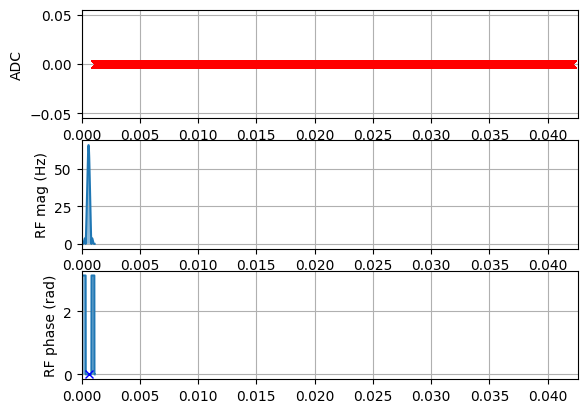

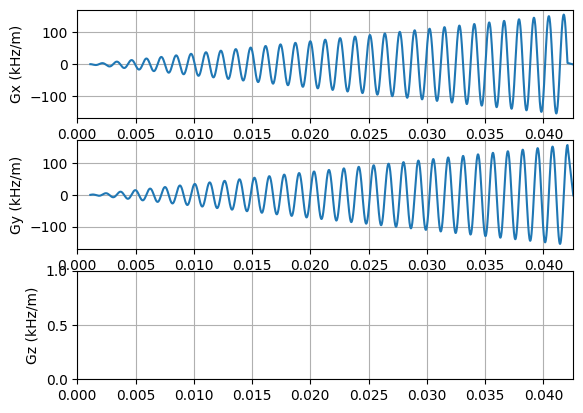

VoxelGridPhantom
size = tensor([0.2000, 0.2000, 0.0080])


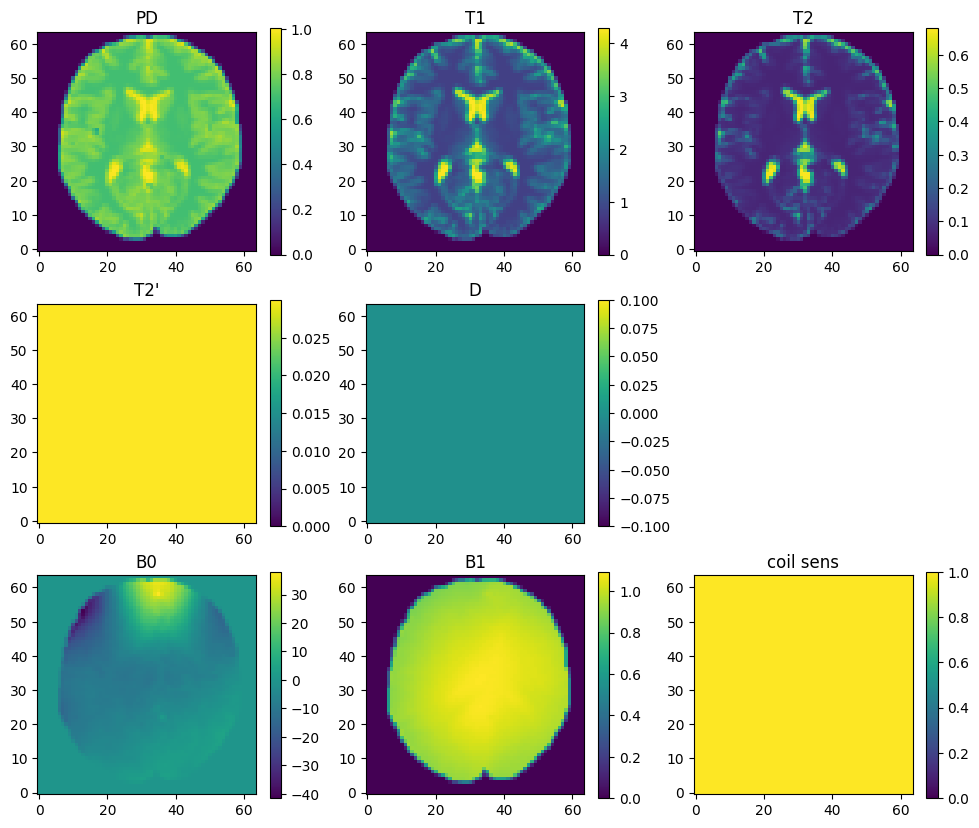

Calculating repetition 1 / 1 - done


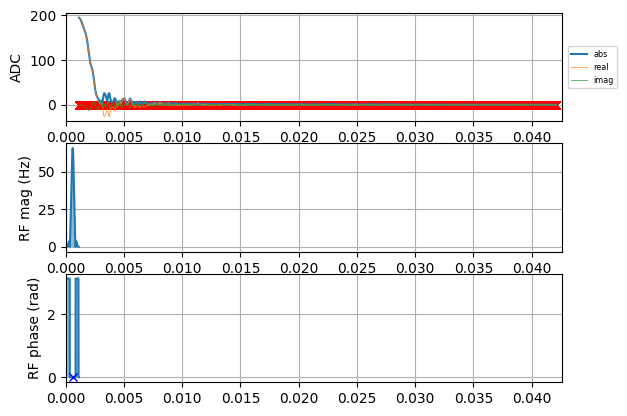

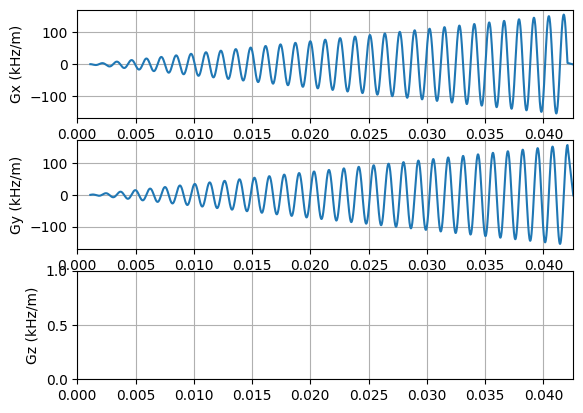

> NUFFT recon with density compensation function
torch.Size([1, 1, 20475]) should be: [batch_size, num_coils,num_samples]
torch.Size([20475]) should be: [num_samples]
nufft_adj -> image shape:  torch.Size([1, 1, 64, 64])


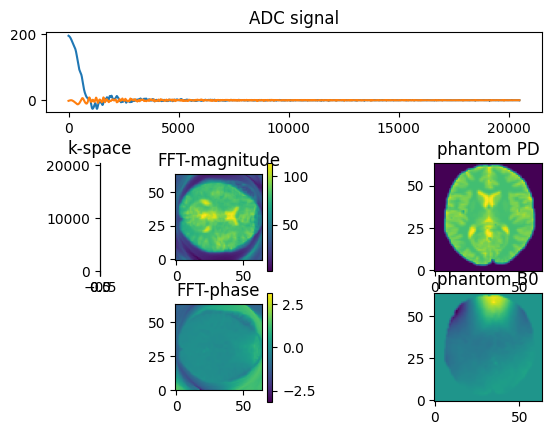

In [ ]:
#@title simulate
# %% S3. CHECK, PLOT and WRITE the sequence  as .seq
# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]

# PLOT sequence
sp_adc, t_adc = mr0.util.pulseq_plot(seq, clear=False, figid=(11,12))

# Prepare the sequence output for the scanner
seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition('Name', 'gre')
seq.write('external.seq')


# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above

if 1:
    # (i) load a phantom object from file
    # obj_p = mr0.VoxelGridPhantom.load_mat('phantom2D.mat')
    obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
    obj_p = obj_p.interpolate(sz[0], sz[1], 1)

# Manipulate loaded data
    obj_p.T2dash[:] = 30e-3
    obj_p.D *= 0
    obj_p.B0 *= 1    # alter the B0 inhomogeneity
    # Store PD for comparison
    PD = obj_p.PD.squeeze()
    B0 = obj_p.B0.squeeze()
else:
    # or (ii) set phantom  manually to a pixel phantom. Coordinate system is [-0.5, 0.5]^3
    obj_p = mr0.CustomVoxelPhantom(
        pos=[[-0.4, -0.4, 0], [-0.4, -0.2, 0], [-0.3, -0.2, 0], [-0.2, -0.2, 0], [-0.1, -0.2, 0]],
        PD=[1.0, 1.0, 0.5, 0.5, 0.5],
        T1=1.0,
        T2=0.1,
        T2dash=0.1,
        D=0.0,
        B0=0,
        voxel_size=0.1,
        voxel_shape="box"
    )
    # Store PD for comparison
    PD = obj_p.generate_PD_map()
    B0 = torch.zeros_like(PD)

obj_p.plot()
obj_p.size=torch.tensor([fov, fov, slice_thickness])
# Convert Phantom into simulation data
obj_p = obj_p.build()


# %% S5:. SIMULATE  the external.seq file and add acquired signal to ADC plot

# Read in the sequence
seq0 = mr0.Sequence.import_file("external.seq")

#seq0.plot_kspace_trajectory()
kspace_loc = seq0.get_kspace()
# Simulate the sequence
graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal = mr0.execute_graph(graph, seq0, obj_p)

# PLOT sequence with signal in the ADC subplot
plt.close(11);plt.close(12)
sp_adc, t_adc = mr0.util.pulseq_plot(seq, clear=False, signal=signal.numpy())

kspace_adc = torch.reshape((signal), (-1, Ninter)).clone().t()

# %% S6:. NUFFT reconstruction with density compensation
# Zhengguo Tan <zhengguo.tan@gmail.com>

fig = plt.figure()  # fig.clf()
plt.subplot(411)
plt.title('ADC signal')
plt.plot(torch.real(signal), label='real')
plt.plot(torch.imag(signal), label='imag')
print('> NUFFT recon with density compensation function')

import torchkbnufft as tkbn
img_shape = sz

# prepare k-space trajectory traj
traj = kspace_loc[:, :2].T  # tkbn assumes xy in the first dim, thus .T
traj = traj / sz[0] * 2 * np.pi # normalize k-space trajectory from -kmax to kmax to -pi to pi for tkbn

if 0:# compute density compensation function manually
    dcf = (traj[0,:]**2 + traj[1,:]**2)**0.5 # density compensation factor
    print(dcf.shape,'should be: [num_samples]')
else:# calculate density compensation function using  tkbn.calc_density_compensation_function
    dcf = tkbn.calc_density_compensation_function(ktraj=traj, im_size=img_shape)
    print(dcf.shape,'should be: [batch_size, num_coils,num_samples]')

# prepare kdat
kdat = signal.squeeze()
print(kdat.shape,'should be: [num_samples]') # should be num_samples

# Reshape kdat and dcf: (1, 1, num_samples) -> (batch_size, num_coils, num_samples) for adjoint
kdat = kdat.reshape(1, 1, -1)
dcf = dcf.reshape(1, 1, -1)

# define nufft adjoint operator
nufft_adj = tkbn.KbNufftAdjoint(im_size=img_shape)
recon_nufft = nufft_adj(kdat*dcf , traj)

print('nufft_adj -> image shape: ', recon_nufft.shape)

space = recon_nufft.numpy().squeeze()
space = np.flip(np.swapaxes(space, -1, -2), -2)

plt.subplot(345)
plt.title('k-space')
mr0.util.imshow(np.abs(kspace_adc))

plt.subplot(346)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space))
plt.colorbar()
plt.subplot(3, 4, 10)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(space), vmin=-np.pi, vmax=np.pi)
plt.colorbar()

# % compare with original phantom obj_p.PD
plt.subplot(348)
plt.title('phantom PD')
mr0.util.imshow(PD)
plt.subplot(3, 4, 12)
plt.title('phantom B0')
mr0.util.imshow(B0)